<a href="https://colab.research.google.com/github/faseenafarz/machine-learning/blob/main/gender_prediction_Resnet18_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter
import numpy as np
import pandas as pd
import os
from tqdm import tqdm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DIR = '/content/drive/MyDrive/UTKFace'

In [ ]:
image_paths = []
gender_labels = []


for filename in tqdm(os.listdir(DIR)):
    image_path = os.path.join(DIR, filename)
    temp = filename.split('_')
    gender = int(temp[1])
    image_paths.append(image_path)
    gender_labels.append(gender)

100%|██████████| 23704/23704 [00:00<00:00, 349436.88it/s]


In [ ]:
# convert to dataframe
df = pd.DataFrame()
df['image'],df['gender'] = image_paths,gender_labels
df.head()

,image,gender
0,/content/drive/MyDrive/UTKFace/80_1_0_20170110...,1
1,/content/drive/MyDrive/UTKFace/80_0_2_20170112...,0
2,/content/drive/MyDrive/UTKFace/80_1_0_20170110...,1
3,/content/drive/MyDrive/UTKFace/80_1_0_20170110...,1
4,/content/drive/MyDrive/UTKFace/80_1_0_20170110...,1


In [ ]:

df['gender'].value_counts()

,count
gender,
0,12389
1,11315


Model Creation

In [ ]:
# Load the features
X_loaded = np.load('/content/drive/MyDrive/features.npy')

In [ ]:
# Load the targets
y_gender = np.array(df['gender'])

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, WeightedRandomSampler, TensorDataset
import numpy as np


In [ ]:
# Load pre-trained ResNet-18 model
resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 200MB/s]


In [ ]:
# Freeze all parameters of the base model
for param in resnet18.parameters():
    param.requires_grad = False

In [ ]:
class ResNet18Gender(nn.Module):
    def __init__(self, original_model):
        super(ResNet18Gender, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-2])  # Use layers up to the second-last layer
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling

        # Custom classification layer for gender
        self.fc = nn.Linear(512, 256)  # Assuming 512 output features from ResNet-18
        self.dropout = nn.Dropout(0.4)
        self.gender_out = nn.Linear(256, 1)  # Binary classification for gender

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = torch.relu(x)
        x = self.dropout(x)
        gender_output = torch.sigmoid(self.gender_out(x))  # Binary classification output
        return gender_output


In [ ]:
# Instantiate the gender classification model
model = ResNet18Gender(resnet18)

In [ ]:
# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary cross-entropy loss for gender
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Convert features to a PyTorch tensor
features = torch.tensor(X_loaded, dtype=torch.float32)
# Convert labels to a PyTorch tensor
labels = torch.tensor(y_gender, dtype=torch.float32)


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert the split data into PyTorch Datasets
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


Training the model

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:

        if inputs.shape[1] == 128:
            inputs = inputs.permute(0, 3, 1, 2)

        optimizer.zero_grad()
        outputs = model(inputs)


        if outputs.shape[1] == 1:
            outputs = outputs.squeeze(1)  # Change shape from [32, 1] to [32]


        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')


Epoch 1/10, Loss: 0.47031280952496796
Epoch 2/10, Loss: 0.42548510294429137
Epoch 3/10, Loss: 0.40692778058019907
Epoch 4/10, Loss: 0.4029714542374675
Epoch 5/10, Loss: 0.39317610624438304
Epoch 6/10, Loss: 0.38440694776229084
Epoch 7/10, Loss: 0.3739439879825809
Epoch 8/10, Loss: 0.3662641581600112
Epoch 9/10, Loss: 0.36563619741584985
Epoch 10/10, Loss: 0.3536173967727117


Validating the model

In [ ]:
model.eval()
val_loss = 0.0
val_correct = 0

with torch.no_grad():
    for inputs, labels in val_loader:
      if inputs.shape[1] == 128:
            inputs = inputs.permute(0, 3, 1, 2)
      outputs = model(inputs).squeeze()
      loss = criterion(outputs, labels)

      val_loss += loss.item() * inputs.size(0)
      preds = outputs.round()
      val_correct += (preds == labels).sum().item()

val_loss /= len(val_loader.dataset)
val_accuracy = val_correct / len(val_loader.dataset)

print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Validation Loss: 0.4109, Validation Accuracy: 0.8068


Testing the model

In [ ]:
test_loss = 0.0
test_correct = 0

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        if inputs.shape[1] == 128:
            inputs = inputs.permute(0, 3, 1, 2)

        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)

        test_loss += loss.item() * inputs.size(0)
        preds = outputs.round()
        test_correct += (preds == labels).sum().item()

test_loss /= len(test_loader.dataset)
test_accuracy = test_correct / len(test_loader.dataset)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.4020, Test Accuracy: 0.8136


In [ ]:
# Save the model
torch.save(model.state_dict(), 'gender_classification_model.pth')


In [ ]:
!cp /content/gender_classification_model.pth /content/drive/MyDrive

Predicting Gender from a Single Image

In [ ]:
import torch
from PIL import Image
from torchvision import transforms
import torchvision.models as models

# Load the pre-trained gender classification model
model = ResNet18Gender(models.resnet18(pretrained=True))
model.load_state_dict(torch.load('/content/drive/MyDrive/gender_classification_model.pth'))
model.eval()


# Preprocess the input image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = preprocess(image).unsqueeze(0)  # Add batch dimension
    return image

# Predict the gender of an input image
def predict_gender(image_path):
    image_tensor = preprocess_image(image_path)

    with torch.no_grad():
        output = model(image_tensor).squeeze()
        prediction = torch.round(output).item()

    return 'Male' if prediction == 1 else 'Female'



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-25-206e3a0cd1e0>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detail

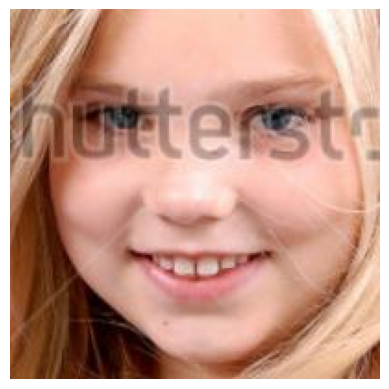

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = "/content/drive/MyDrive/UTKFace/11_1_0_20170109205136852.jpg.chip.jpg"

image = mpimg.imread(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
# Example usage

predicted_gender = predict_gender(image_path)
print(f"Predicted Gender: {predicted_gender}")

Predicted Gender: Female
